## Changing the loss from going off the index to the actual values of score

Remember we will actually be giving the NN as input a noisy score and use the real score to calculate the loss.

In [1]:
import torch
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
def generate_population(num_populations: int, num_individuals: int, num_markers: int, ploidy: int) -> torch.Tensor:
    """
    Generate a population tensor for plant breeding.

    Parameters:
    num_populations (int): The number of populations.
    num_individuals (int): The number of individuals per population.
    num_markers (int): The number of genetic markers.
    ploidy (int): The ploidy level of the plants (e.g., diploid, haploid).

    Returns:
    torch.Tensor: A tensor of shape (num_populations, num_individuals, num_markers, ploidy)
                  with binary values representing the genetic makeup.
    """
    population_tensor = torch.randint(2, (num_populations, num_individuals, num_markers, ploidy), dtype=torch.int8)
    return population_tensor


# Example test
num_populations = 3
num_individuals = 50
num_markers = 100
ploidy = 2

test_tensor = generate_population(num_populations, num_individuals, num_markers, ploidy)
assert test_tensor.shape == (num_populations, num_individuals, num_markers, ploidy)
assert test_tensor.dtype == torch.int8
assert test_tensor.ge(0).all() and test_tensor.le(1).all(), "Tensor should only contain 0s and 1s"

def generate_map(number_markers:int):
    """The genetic map represents the rules of the game. It assigns the truth value to each marker.

    :param number_markers: the total number of markers to include in this genetic map. must correspond to population shape
    :type number_markers: int 
    """
    # 'chr' will always be '1A' for every marker
    chr_array = ['1A'] * number_markers
    
    # 'yield': Create a marker_strength array with 1 float between -0.5 and +0.5 randomly
    # yield_array = np.random.poisson(np.random.randint(1,10), size=number_markers)
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)

    # Scale the Poisson values to the range [0, 1]
    scaled_poisson_values = poisson_values / np.max(poisson_values)

    # Stretch and shift the values to the range [-1, 1]
    yield_array = (scaled_poisson_values * 2) - 1
    
    # 'cM': create an array for number_markers length evenly sampled between 0 and 100
    cM_array = np.linspace(0, 100, num=number_markers)
    
    # Create the DataFrame with the auto-generated data
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    
    return df

num_markers = 100
map = generate_map(num_markers)
def generate_scores(test_pop: torch.Tensor, test_map: pd.DataFrame) -> torch.Tensor:
    """
    Generate scores for each individual in each population based on the genetic markers and yield values.

    Parameters:
    test_pop (torch.Tensor): A tensor representing the population with shape (num_populations, num_individuals, num_markers, ploidy).
    test_map (pd.DataFrame): A DataFrame containing the 'Yield' values for each marker.

    Returns:
    torch.Tensor: A tensor of shape (num_populations, num_individuals) representing the scores of each individual.
    """
    # Sum the binary ploidy axes for each individual
    summed_ploidy = test_pop.sum(dim=-1)
    
    # Convert test_map['Yield'] to a tensor and perform matrix multiplication
    yield_values = torch.tensor(test_map['Yield'].values, dtype=torch.float32)
    scores = torch.matmul(summed_ploidy.float(), yield_values)
    
    return scores

def get_top_indices(scores: torch.Tensor, top_x: int) -> torch.Tensor:
    """
    Get the indices of the top X scores for each population.

    Parameters:
    scores (torch.Tensor): A tensor of shape (num_populations, num_individuals) representing the scores of each individual.
    top_x (int): The number of top indices to return for each population.

    Returns:
    torch.Tensor: A tensor containing the indices of the top X scores for each population.
    """
    # Use torch.topk to get the top X values and their indices for each population
    top_values, top_indices = torch.topk(scores, k=top_x, dim=1, largest=True, sorted=True)

    return top_indices


def select_top_individuals(test_pop: torch.Tensor, top_index: torch.Tensor) -> torch.Tensor:
    """
    Select the top individuals from each population based on the top indices.

    Parameters:
    test_pop (torch.Tensor): A tensor of shape (num_populations, num_individuals, num_markers, ploidy)
                             representing the populations.
    top_index (torch.Tensor): A tensor of shape (num_populations, top_x) containing the indices of the top
                              individuals in each population.

    Returns:
    torch.Tensor: A tensor of shape (num_populations, top_x, num_markers, ploidy) containing the top individuals.
    """
    # Get the number of populations and the number of top individuals to select
    num_populations, top_x = top_index.shape
    
    # Create a tensor of population indices that correspond to each individual
    population_indices = torch.arange(num_populations).view(-1, 1).expand(-1, top_x).reshape(-1)
    
    # Expand top_index to match the total number of individuals selected
    expanded_top_index = top_index.reshape(-1)
    
    # Select the top individuals across the second dimension (individuals)
    selected_individuals = torch.index_select(test_pop.view(-1, *test_pop.shape[2:]), 0, population_indices * test_pop.shape[1] + expanded_top_index)
    
    # Reshape the result to the desired output shape
    selected_individuals = selected_individuals.view(num_populations, top_x, *test_pop.shape[2:])
    
    return selected_individuals


def generate_offspring(selected_parents: torch.Tensor, total_offspring: int) -> torch.Tensor:
    """
    Generate offspring tensors by randomly inheriting one ploidy value from each of the parents.

    Parameters:
    selected_parents (torch.Tensor): A tensor of shape (population, individual, marker, ploidy)
                                     representing the selected parents.
    total_offspring (int): The total number of offspring to generate for each population.

    Returns:
    torch.Tensor: A tensor representing the offspring with shape (population, total_offspring, marker, ploidy).
    """
    num_populations, num_individuals, num_markers, ploidy = selected_parents.shape
    
    # Initialize an empty tensor for the offspring with the correct shape
    offspring = torch.empty((num_populations, total_offspring, num_markers, ploidy), dtype=torch.int8)
    
    # Iterate over each population
    for pop in range(num_populations):
        # Generate offspring for the population
        for off in range(total_offspring):
            # Randomly select two parents for each offspring
            parents_idx = torch.randint(0, num_individuals, (2,))
            for marker in range(num_markers):
                # Randomly select one ploidy value from each parent for each marker
                alleles = torch.stack([
                    selected_parents[pop, parents_idx[0], marker, torch.randint(0, ploidy, (1,))],
                    selected_parents[pop, parents_idx[1], marker, torch.randint(0, ploidy, (1,))]
                ])
                offspring[pop, off, marker] = alleles.squeeze()

    return offspring


# Example test
num_populations = 3
num_individuals = 50
num_markers = 100
ploidy = 2

test_pop = generate_population(num_populations, num_individuals, num_markers, ploidy)
test_map = generate_map(num_markers)
test_score = generate_scores(test_pop, test_map)

print(f'{type(test_pop)}') # torch.tensor
print(f'{type(test_map)}') # torch.tensor
print(f'{type(test_map["Yield"])}') # torch.tensor

top_index = get_top_indices(test_score, 6)
selected_parents = select_top_individuals(test_pop, top_index)
# Assuming selected_parents is a tensor with the shape (batch, population, individual, marker, ploidy)
offspring = generate_offspring(selected_parents,50)

<class 'torch.Tensor'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [3]:
import torch
import numpy as np
import pandas as pd

# Function to generate population tensor
def generate_population(num_populations: int, num_individuals: int, num_markers: int, ploidy: int) -> torch.Tensor:
    population_tensor = torch.randint(2, (num_populations, num_individuals, num_markers, ploidy), dtype=torch.int8)
    return population_tensor

# Function to generate map
def generate_map(number_markers:int):
    chr_array = ['1A'] * number_markers
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)
    scaled_poisson_values = poisson_values / np.max(poisson_values)
    yield_array = (scaled_poisson_values * 2) - 1
    cM_array = np.linspace(0, 100, num=number_markers)
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    return df

# Function to generate scores
def generate_scores(test_pop: torch.Tensor, test_map: pd.DataFrame) -> torch.Tensor:
    summed_ploidy = test_pop.sum(dim=-1)
    yield_values = torch.tensor(test_map['Yield'].values, dtype=torch.float32)
    scores = torch.matmul(summed_ploidy.float(), yield_values)
    return scores

# Function to get top indices
def get_top_indices(scores: torch.Tensor, top_x: int) -> torch.Tensor:
    top_values, top_indices = torch.topk(scores, k=top_x, dim=1, largest=True, sorted=True)
    return top_indices

# Function to select top individuals
def select_top_individuals(test_pop: torch.Tensor, top_index: torch.Tensor) -> torch.Tensor:
    num_populations, top_x = top_index.shape
    population_indices = torch.arange(num_populations).view(-1, 1).expand(-1, top_x).reshape(-1)
    expanded_top_index = top_index.reshape(-1)
    selected_individuals = torch.index_select(test_pop.view(-1, *test_pop.shape[2:]), 0, population_indices * test_pop.shape[1] + expanded_top_index)
    selected_individuals = selected_individuals.view(num_populations, top_x, *test_pop.shape[2:])
    return selected_individuals

# Function to generate offspring
def generate_offspring(selected_parents: torch.Tensor, total_offspring: int) -> torch.Tensor:
    num_populations, num_individuals, num_markers, ploidy = selected_parents.shape
    offspring = torch.empty((num_populations, total_offspring, num_markers, ploidy), dtype=torch.int8)
    for pop in range(num_populations):
        for off in range(total_offspring):
            parents_idx = torch.randint(0, num_individuals, (2,))
            for marker in range(num_markers):
                alleles = torch.stack([
                    selected_parents[pop, parents_idx[0], marker, torch.randint(0, ploidy, (1,))],
                    selected_parents[pop, parents_idx[1], marker, torch.randint(0, ploidy, (1,))]
                ])
                offspring[pop, off, marker] = alleles.squeeze()
    return offspring




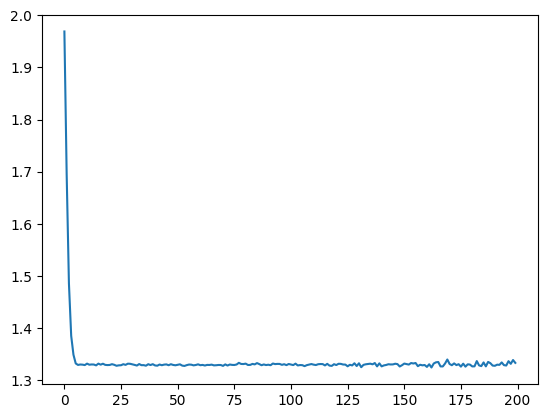

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, logits, targets):
        batch_size, n_classes = logits.size()
        # Convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)
        
        # Create a mask of size [batch_size, n_classes] where each row contains zeros and ones at the target indices
        mask = torch.zeros_like(probabilities).scatter_(1, targets, 1.0)
        
        # Multiply probabilities with the mask, sum along classes dimension to get the probabilities of target indices
        target_probs = probabilities * mask
        target_probs_sum = target_probs.sum(dim=1)
        
        # Loss is the negative log of summed probabilities of target indices
        loss = -torch.log(target_probs_sum + 1e-9) # Adding epsilon to avoid log(0)
        return loss.mean()

class MLP(nn.Module):
    def __init__(self, n, hs,o):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n, hs),  # Adjusted to match input and output size
            nn.ReLU(),
            nn.Linear(hs, o)
        )

    def forward(self, x):
        return self.layers(x)
    


#setting up population
    
num_populations = 6
num_individuals = 100
num_markers = 500
ploidy = 2

test_map = generate_map(num_markers)
test_pop = generate_population(num_populations, num_individuals, num_markers, ploidy)
test_score = generate_scores(test_pop, test_map)

top_index = get_top_indices(test_score, 5)
selected_parents = select_top_individuals(test_pop, top_index)
offspring = generate_offspring(selected_parents,50)

#setting up NN
topk= 10
hs = 5

model = MLP(num_individuals * num_markers * ploidy, hs, num_individuals)
opt = torch.optim.Adam(model.parameters(), lr =.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

loss_fn = CustomLoss()
targets = torch.topk(test_score, topk)

history = []
# Training loop skeleton (requires actual loop implementation)
for epoch in range(2000):  # Example: 100 epochs
    test_pop = generate_population(num_populations, num_individuals, num_markers, ploidy)
    test_score = generate_scores(test_pop, test_map)
    model_out = model(test_pop.flatten(start_dim=1).float())  # Forward pass
    loss = loss_fn(model_out, targets.indices)  # Loss computation
    opt.zero_grad()  # Zero gradients
    loss.backward()  # Backward pass
    opt.step()  # Update parameters
    # scheduler.step()  # Adjust learning rate
    if epoch % 10 == 9:
        history.append(loss.detach().numpy())

plt.plot(history)

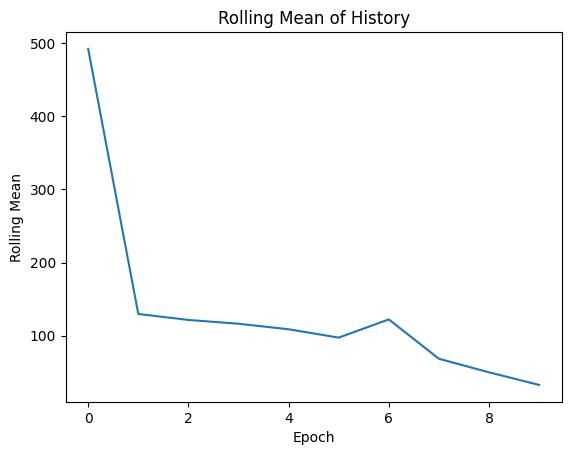

In [5]:
#Score only

import torch
import torch.nn as nn
import torch.nn.functional as F

class NegativeL1Loss(nn.Module):
    def __init__(self, topk):
        super(NegativeL1Loss, self).__init__()
        self.l1_loss = nn.L1Loss()
        self.topk = topk

    def forward(self, model_out, test_score):
        picked = torch.topk(model_out, self.topk)
        picked = torch.gather(test_score, 1, picked.indices)
        picked = torch.mean(picked,dim=1, keepdim=False)
        bench = torch.mean(test_score, dim=1)
        return -self.l1_loss(picked, bench)

class MLP(nn.Module):
    def __init__(self, n, hs, o):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n, hs),  # Adjusted to match input and output size
            nn.ReLU(),
            nn.Linear(hs, o)
        )

    def forward(self,test_score):
        out = self.layers(test_score)
        return out
    


#setting up population
    
num_populations = 3
num_individuals = 200
num_markers = 1000
ploidy = 2

test_map = generate_map(num_markers)
test_pop = generate_population(num_populations, num_individuals, num_markers, ploidy)
test_score = generate_scores(test_pop, test_map).requires_grad_()

top_index = get_top_indices(test_score, 5)
selected_parents = select_top_individuals(test_pop, top_index)
offspring = generate_offspring(selected_parents,50)

#setting up NN
topk= 50
hs = 100

model = MLP(num_individuals, hs, num_individuals)
opt = torch.optim.Adam(model.parameters(), lr =.01)

loss_fn = nn.MSELoss()  # Use mean squared error loss

history = []
# Training loop
for epoch in range(1000):  # Example: 100 epochs

    model_out = model(test_score)  # Forward pass
    loss = loss_fn(model_out, test_score)  # Loss computation

    opt.zero_grad()  # Zero gradients
    loss.backward()  # Backward pass
    opt.step()  # Update parameters

    if epoch % 100 == 99:
        history.append(loss.detach().numpy())


history_series = pd.Series(history)

# Calculate the rolling mean with a window size of 1000
rolling_mean = history_series.rolling(window=2).mean()

# Plot the rolling mean
plt.plot(history_series)
plt.xlabel('Epoch')
plt.ylabel('Rolling Mean')
plt.title('Rolling Mean of History')
plt.show()


In [69]:
import torch
from torch import nn

class Actor(nn.Module):
    def __init__(self, population_size, marker_count, ploidy, hidden_size):
        super(Actor, self).__init__()

        # Define separate layers for each input
        self.remaining_cycles_layer = nn.Linear(1, hidden_size)
        self.population_layer = nn.Linear(population_size * marker_count *ploidy, hidden_size)
        self.scores_layer = nn.Linear(population_size, hidden_size)

        # Combine the outputs of the above layers into a single hidden layer
        self.combined_layer = nn.Linear(hidden_size * 3, hidden_size)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, population_size)

    def forward(self, remaining_cycles, population, scores):
        # Pass each input through its own layer
        remaining_cycles_out = torch.relu(self.remaining_cycles_layer(remaining_cycles))
        population_out = torch.relu(self.population_layer(population)).squeeze(-1)
        scores_out = torch.relu(self.scores_layer(scores)).squeeze(-1)

        # Combine the outputs of the above layers
        combined_out = torch.cat((remaining_cycles_out, population_out, scores_out), dim=-1)
        combined_out = torch.relu(self.combined_layer(combined_out))

        # Pass the combined output through the output layer
        output = self.output_layer(combined_out)

        # Apply softmax to the output to get probabilities
        output = F.softmax(output, dim=-1)

        return output    
    

class Critic(nn.Module):
    def __init__(self, population_size, marker_count, ploidy, hidden_size):
        super(Critic, self).__init__()

        # Define separate layers for each input
        self.remaining_cycles_layer = nn.Linear(1, hidden_size)
        self.population_layer = nn.Linear(population_size * marker_count * ploidy, hidden_size)
        self.scores_layer = nn.Linear(population_size, hidden_size)
        self.actor_output_layer = nn.Linear(population_size, hidden_size)

        # Combine the outputs of the above layers into a single hidden layer
        self.combined_layer = nn.Linear(hidden_size * 4, hidden_size)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, remaining_cycles, population, scores, actor_output):
        # Pass each input through its own layer
        remaining_cycles_out = torch.relu(self.remaining_cycles_layer(remaining_cycles))
        population_out = torch.relu(self.population_layer(population)).squeeze(-1)
        scores_out = torch.relu(self.scores_layer(scores)).squeeze(-1)
        actor_output_out = torch.relu(self.actor_output_layer(actor_output)).squeeze(-1)

        # Combine the outputs of the above layers
        combined_out = torch.cat((remaining_cycles_out, population_out, scores_out, actor_output_out), dim=-1)
        combined_out = torch.relu(self.combined_layer(combined_out))

        # Pass the combined output through the output layer
        output = self.output_layer(combined_out)

        return output
    


num_populations = 1
num_individuals = 25
num_markers = 25
ploidy = 2
hidden_size = 5
total_epochs = 200
topk = 2
lr = .001


test_map = generate_map(num_markers)
test_pop = generate_population(num_populations, num_individuals, num_markers, ploidy)
test_score = generate_scores(test_pop, test_map).requires_grad_()
# Subtract the mean and divide by the standard deviation
test_score_normalized = (test_score - torch.mean(test_score, dim=1, keepdim=True)) / torch.std(test_score, dim=1, keepdim=True)# top_index = get_top_indices(test_score, 5)
# selected_parents = select_top_individuals(test_pop, top_index)
# offspring = generate_offspring(selected_parents,50)
A = Actor(num_individuals, num_markers, ploidy, hidden_size)
C = Critic(num_individuals, num_markers, ploidy, hidden_size)
# Define the optimizers
actor_optimizer = torch.optim.Adam(A.parameters(), lr=lr)
critic_optimizer = torch.optim.Adam(C.parameters(), lr =lr)
remaining_cycles = torch.full((num_populations, 1), 10.0)
flattened_test_pop = test_pop.view(test_pop.shape[0], -1)

rewards = []
actor_losses = []
critic_losses = []
actor_output_values = []
step_size = total_epochs // 20

for epoch in range(total_epochs):
    # Generate the actor output
    actor_output = A(remaining_cycles.float(), flattened_test_pop.float(), test_score.float())
    # Generate the critic output
    critic_output = C(remaining_cycles.float(), flattened_test_pop.float(), test_score.float(), actor_output)

    sampled_indices = torch.multinomial(actor_output, num_samples= topk, replacement=True)
    sampled_indices
    batch_indices = torch.arange(actor_output.size(0)).unsqueeze(1)
    filtered_array = test_pop[batch_indices, sampled_indices]

    new_pop = generate_offspring(filtered_array, num_individuals*10)
    new_scores = generate_scores(new_pop, test_map)
    old_scores = test_score

    reward = new_scores.mean() - old_scores.mean()
    reward = reward.view(1, 1)
    # reward = torch.mean(reward, dim = 1, keepdim=True)
    # Calculate the critic loss
    critic_loss = F.mse_loss(critic_output, reward)

    # Calculate the actor loss
    actor_loss = -torch.sum((reward - critic_output.detach()))
    
    # Zero the gradients
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()

    # Calculate the gradients
    critic_loss.backward(retain_graph=True)
    actor_loss.backward()

    # Update the weights
    critic_optimizer.step()
    actor_optimizer.step()

    # Append the losses and reward to the lists
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    rewards.append(reward.mean().item())
    if epoch % step_size == 0:
        actor_output_values.append(actor_output.detach().numpy())


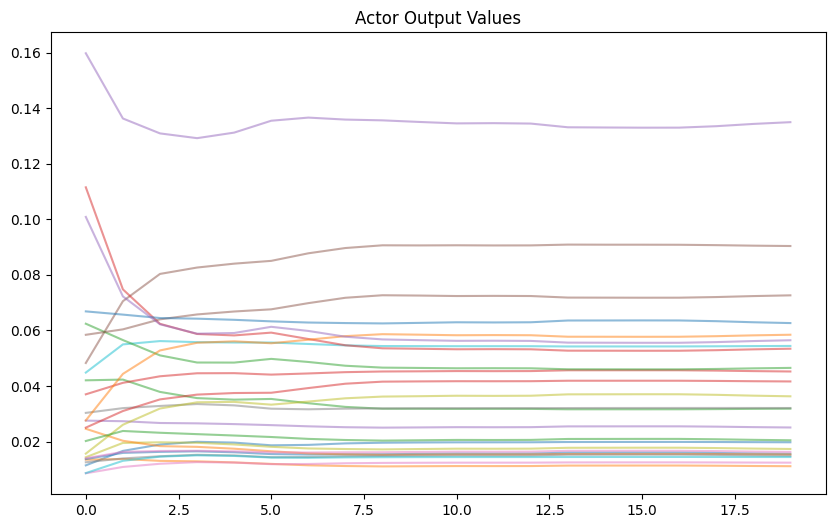

In [70]:
actor_output_values = np.array(actor_output_values)
# Get the shape of actor_output_values
steps, batch_size, number_of_lines = np.array(actor_output_values).shape

# Plot each line with some opacity
plt.figure(figsize=(10, 6))
for i in range(number_of_lines):
    plt.plot(actor_output_values[:, 0, i], alpha=0.5)

plt.title('Actor Output Values')
plt.show()

In [71]:
torch.topk(actor_output,5)

torch.return_types.topk(
values=tensor([[0.1350, 0.0904, 0.0726, 0.0627, 0.0585]], grad_fn=<TopkBackward0>),
indices=tensor([[14,  5, 15, 20, 21]]))

In [72]:
torch.topk(test_score,10)

torch.return_types.topk(
values=tensor([[-1.0000, -2.5000, -3.0000, -3.0000, -3.0000, -3.5000, -3.5000, -4.0000,
         -4.0000, -5.0000]], grad_fn=<TopkBackward0>),
indices=tensor([[19,  1, 24, 12,  4,  3,  5,  9,  6, 16]]))

In [32]:
actor_output_values[:,0,:].shape

(20, 25)

In [48]:
tophit = np.argmax(actor_output_values[:, 0, -1])

In [49]:
test_score[0][tophit]

tensor(0.7500, grad_fn=<SelectBackward0>)

In [57]:

actor_output_values[:, 0, -1][0]

0.045938455

In [58]:
actor_output_values[:, 0, -1][13]

0.031542514

In [53]:
test_score[0]

tensor([ 0.7500, -2.0000, -0.2500, -2.5000,  0.0000, -2.7500, -0.5000, -1.2500,
        -2.5000, -1.5000,  0.2500, -1.7500, -2.2500,  1.0000, -3.7500, -1.2500,
         0.2500, -1.5000, -1.0000, -3.2500, -1.0000,  0.5000, -1.7500, -1.7500,
        -1.0000], grad_fn=<SelectBackward0>)

In [52]:
torch.topk(,1)

torch.return_types.topk(
values=tensor([1.], grad_fn=<TopkBackward0>),
indices=tensor([13]))

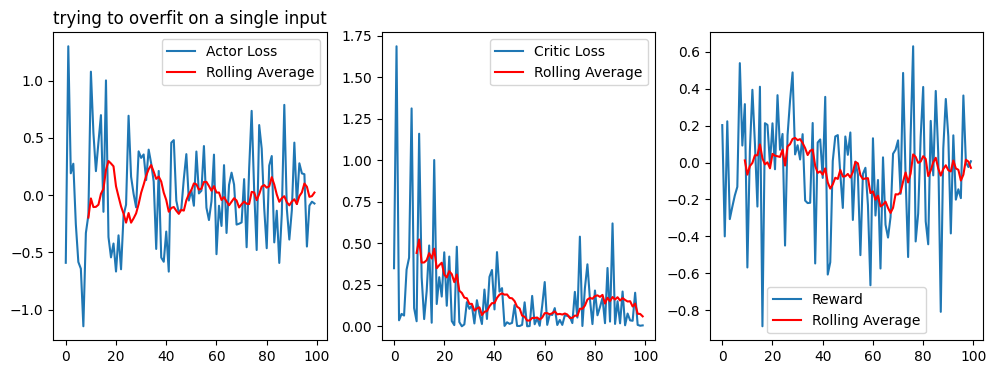

In [21]:
import pandas as pd

# Convert the lists to pandas Series
actor_losses_series = pd.Series(actor_losses)
critic_losses_series = pd.Series(critic_losses)
rewards_series = pd.Series(rewards)

# Calculate the window size as 10% of the length of the input data
window_size = len(actor_losses) // 10

# Calculate the rolling averages
actor_losses_rolling_avg = actor_losses_series.rolling(window=window_size).mean()
critic_losses_rolling_avg = critic_losses_series.rolling(window=window_size).mean()
rewards_rolling_avg = rewards_series.rolling(window=window_size).mean()

# Plot the actor loss, critic loss, rewards, and their rolling averages
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(actor_losses, label='Actor Loss')
plt.plot(actor_losses_rolling_avg, label='Rolling Average', color='red')
plt.legend()
plt.title('trying to overfit on a single input')
plt.subplot(1, 3, 2)
plt.plot(critic_losses, label='Critic Loss')
plt.plot(critic_losses_rolling_avg, label='Rolling Average', color='red')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(rewards, label='Reward')
plt.plot(rewards_rolling_avg, label='Rolling Average', color='red')
plt.legend()

plt.show()